This tutorial serves as a guide to generating polarized PSFs and full frame detector images using the excam coronagraph mode, which simulates the inclusion of either a 0 degree or 45 degree rotated wollaston prism in the optical path. With the prisms, we are able to generate either a 0/90 degree polarized PSF pair or a 45/135 degree polarized PSF pair and place the image pairs accordingly on the EMCCD detector.

In [1]:
#import statements
from corgisim import scene
from corgisim import instrument
import matplotlib.pyplot as plt
import numpy as np
import proper
import roman_preflight_proper
roman_preflight_proper.copy_here()

c:\Users\28908\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here, we initialize a scene and define properties of the host star and point source companion. Note the addition of the parameter `companion_pol`, which describes how the light coming from the companion is polarized through the Stokes parameters (I Q U V). If none is provided, the default setting treats the companion light as unpolarized. Here, we defined the companion to be partially polarized in the horizontal direction.

In [2]:
Vmag = 8
sptype = 'G0V'
mag_companion = 25

#hlc
companion_x_pos = 148
companion_y_pos = 148

#spc-wide
#companion_x_pos = 740
#companion_y_pos = 740

# Companion Stokes parameters I Q U V
companion_pol = np.array([1, 0.4, 0, 0])

host_star_properties = {'Vmag': Vmag, 'spectral_type': sptype, 'magtype':'vegamag'}
point_source_info = [{'Vmag': mag_companion, 'magtype': 'vegamag','position_x':companion_x_pos , 'position_y':companion_y_pos, 'pol_state': companion_pol}]
base_scene = scene.Scene(host_star_properties, point_source_info)

Adding 1 off-axis sources


We then define the parameters used to initialize the instrument. In order to generate polarized images, we must specify which wollaston prism we want to use. This is done via the parameter `wollaston_prism`. Setting `wollaston_prism` to `0` omits the use of any prisms and generates an image that is not polarized. Setting `wollaston_prism` to `1` lets us use the nonrotated prism which produces an image pair that is linearly polarized at 0 and 90 degrees. Setting  `wollaston_prism` to `2` lets us use the prism that's rotated by 45 degrees, which produces an image pair that is linearly polarized at 45 and 135 degrees. We will first set `wollaston_prism` to `1` and produce the 0/90 image pair. By default, we will be working with HLC band 1, since it takes less time to simulate. However, polarimetry mode is also available with SPC wide FOV band 4. If you want to also generate SPC-wide outputs, the instrument parameters for SPC-wide are also included but commented out.

In [3]:
##define instrument parameters
cgi_mode = 'excam'

#hlc
bandpass_corgisim = '1F'
cor_type = 'hlc'
output_dim = 51  
rootname = 'hlc_ni_3e-8'

#spc-wide
#bandpass_corgisim = '4F'
#cor_type = 'spc-wide'
#output_dim = 201  
#rootname = 'spc-wide_ni_2e-8'

#define which wollaston prism to use
wollaston_prism = 1 

dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )

The complete image describing the full scene is a sum of the host star & speckle field image and the point source image. Currently, the polarized speckle field image is computed by incoherently averaging the output electric field intensities along one of the four supported linear polarization directions when two separate orthogonally polarized wavefronts (+45 degree linear and -45 degree linear in our case) are inputted. Meanwhile, the polarized point source companion image is computed by first propagating the point source Stokes vector through the pupil-average instrument Mueller matrix and one of the four linear polarizer Mueller matrices, before scaling the unpolarized point source intensity image by the normalized total intensity (I component) of the final source Stokes vector after the instrument and polarizer. Future work may be done to so that the speckle field and point source polarization are computed with the same method. 

In [4]:
#initialize instrument and generate 0/90 PSF pair
optics_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=wollaston_prism, optics_keywords=optics_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf_polarized(base_scene)
image_star_corgi_horizontal = sim_scene.host_star_image.data[0]
image_star_corgi_vertical = sim_scene.host_star_image.data[1]
sim_scene = optics.inject_point_sources_polarized(base_scene, sim_scene)
image_comp_corgi_horizontal = sim_scene.point_source_image.data[0]
image_comp_corgi_vertical = sim_scene.point_source_image.data[1]
image_tot_corgi_horizontal = image_star_corgi_horizontal + image_comp_corgi_horizontal
image_tot_corgi_vertical = image_star_corgi_vertical + image_comp_corgi_vertical

CorgiOptics initialized with proper keywords.


We will now plot the generated image pair side by side. Note that in the unpolarized case, the image data is simply a 2D array describing the intensity at each location on the image. However, with the use a wollaston prism, an image pair is generated. Hence in this case, the image data will have an extra dimension corresponding to the two orthogonal polarizations produced by the prism. Here, `data[0,:,:]` gives us the 0 degree polarized image and `data[1,:,:]` gives us the 90 degree polarized image. 

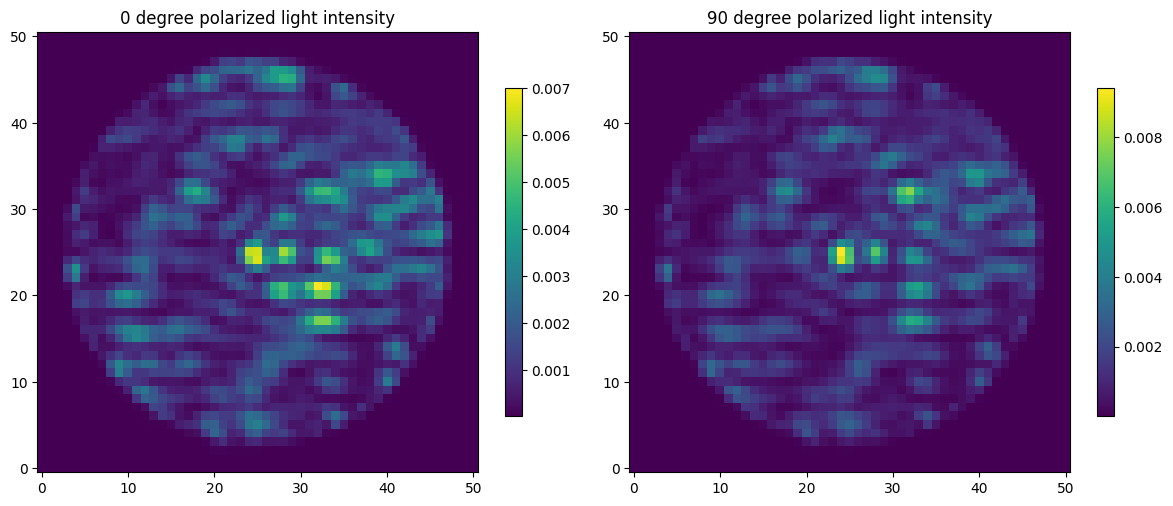

In [5]:
#plot 0/90 pair
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(image_tot_corgi_horizontal, origin='lower')
axes[0].set_title('0 degree polarized light intensity')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

im2 = axes[1].imshow(image_tot_corgi_vertical, origin='lower')
axes[1].set_title('90 degree polarized light intensity')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()

We can also take the difference of the 0 and 90 degree image to obtain the Stokes Q parameter of the final image. Note that this is not equivalent to the actual Stokes Q of the star and companion, due to the effects of instrument polarization and polarization aberrations. By obtaining the difference image, we see that the companion is also more clearly visible due to it having preferential polarization in one of the two polarization basis. 

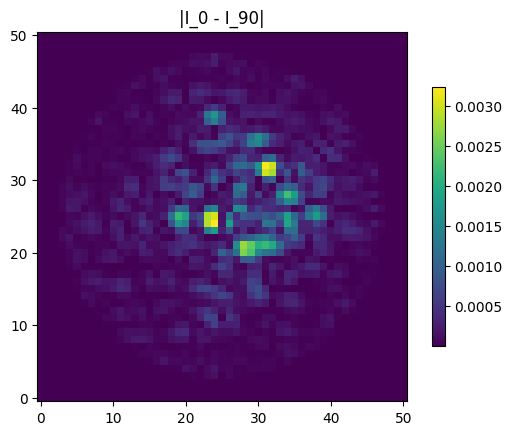

In [6]:
#plot 0/90 difference image
plt.imshow(np.abs(image_tot_corgi_horizontal - image_tot_corgi_vertical), origin='lower')
plt.title('|I_0 - I_90|')

co = plt.colorbar(shrink=0.7)

Now, we will add in detector noise to simulate what the output on the EMCCD detector will look like. We can generate subframe images to simulate what each individual image looks like with detector noise. We can also generate a full-frame image which places the image pair onto the same detector. The wollaston prism splits the original image in a way such that the image pair is separated by 7.5" on the detector. The 0/90 images are aligned horizontally while the 45/135 images are aligned diagonally. 

In [7]:
#initialize detector
gain =100
cr_rate = 0
emccd_keywords ={'em_gain':gain, 'cr_rate':cr_rate}
detector = instrument.CorgiDetector(emccd_keywords)

In [8]:
#subframe detector image 0/90
#just like the noise-free images, the noisy image data is 3D instead of 2D to account for the image pair
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime)
image_tot_corgi_sub_0= sim_scene.image_on_detector.data[0]
image_tot_corgi_sub_90= sim_scene.image_on_detector.data[1]

C:\Users\28908\OneDrive\文档\CorGi\corgisim\corgisim\instrument.py:1157: UserWarning: Detector noise will be different for each sub frame in polarimetry mode. For accurate detector image with noise, please generate full frame image.
  warnings.warn('Detector noise will be different for each sub frame in polarimetry mode. For accurate detector image with noise, please generate full frame image.')


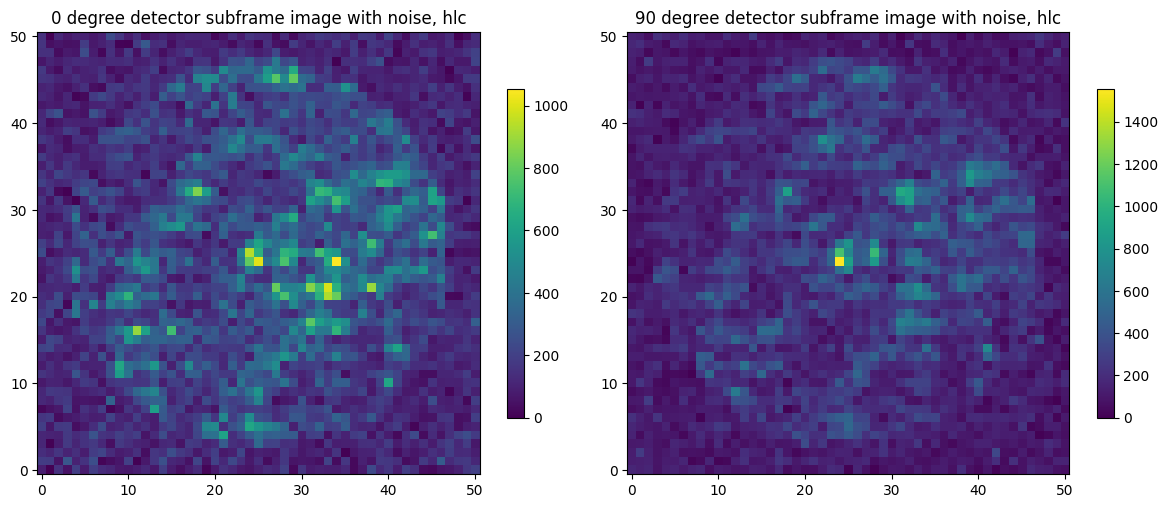

In [9]:
#plot noisy subframe images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(image_tot_corgi_sub_0, origin='lower')
axes[0].set_title('0 degree detector subframe image with noise, hlc')
fig.colorbar(im1, ax=axes[0], shrink=0.7)

im2 = axes[1].imshow(image_tot_corgi_sub_90, origin='lower')
axes[1].set_title('90 degree detector subframe image with noise, hlc')
fig.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()


In [10]:
#generate full frame detector image
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True, loc_x=512, loc_y=512)
image_tot_corgi_full = sim_scene.image_on_detector[1].data

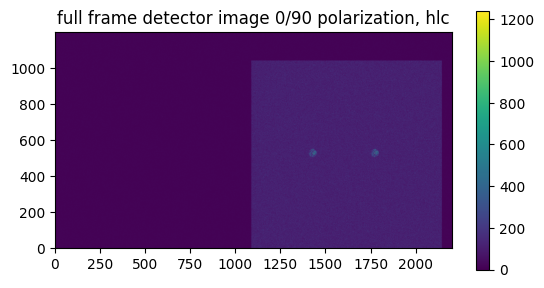

In [11]:
#plot full frame image
plt.imshow(image_tot_corgi_full,origin='lower')
plt.title('full frame detector image 0/90 polarization, hlc')

co = plt.colorbar(shrink=0.7)

Now, we will repeat the process with 45/135 degree images. We do this by setting `wollaston_prism` to `2`, everything else works exactly the same way. 

In [12]:
wollaston_prism = 2

In [13]:
#generate 45/135 PSF pair
optics_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':10, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=wollaston_prism, optics_keywords=optics_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf_polarized(base_scene)
image_star_corgi_45 = sim_scene.host_star_image.data[0]
image_star_corgi_135 = sim_scene.host_star_image.data[1]
sim_scene = optics.inject_point_sources_polarized(base_scene, sim_scene)
image_comp_corgi_45 = sim_scene.point_source_image.data[0]
image_comp_corgi_135 = sim_scene.point_source_image.data[1]
image_tot_corgi_45 = image_star_corgi_45 + image_comp_corgi_45
image_tot_corgi_135 = image_star_corgi_135 + image_comp_corgi_135

CorgiOptics initialized with proper keywords.


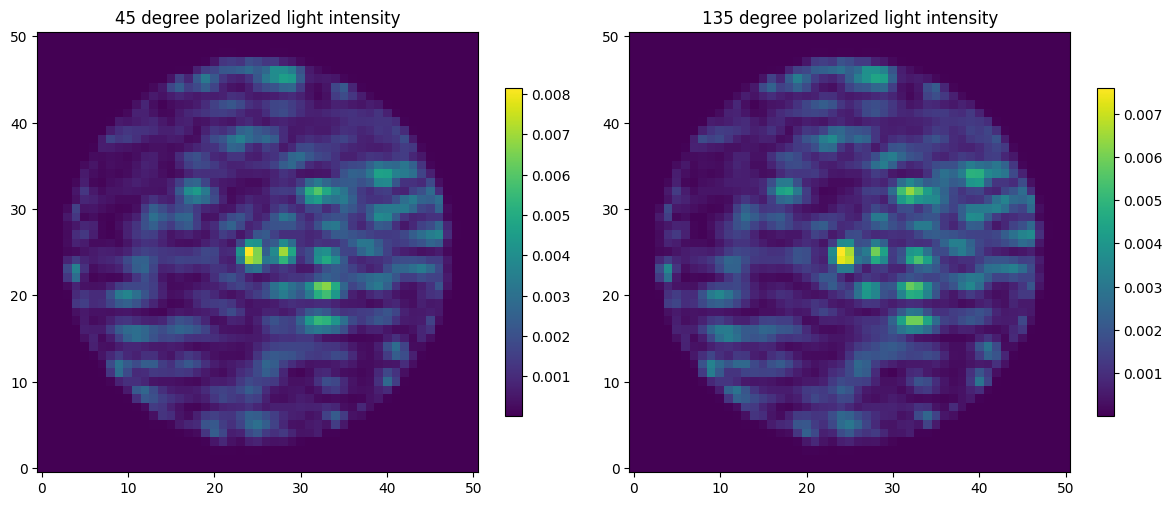

In [14]:
#plot 45/135 pair
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(image_tot_corgi_45, origin='lower')
axes[0].set_title('45 degree polarized light intensity')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

im2 = axes[1].imshow(image_tot_corgi_135, origin='lower')
axes[1].set_title('135 degree polarized light intensity')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()

Similarly, we can take the difference between the 45 degree image and the 135 degree image to subtract out polarization components common to both directions and obtain the observed Stokes U of the final image. 

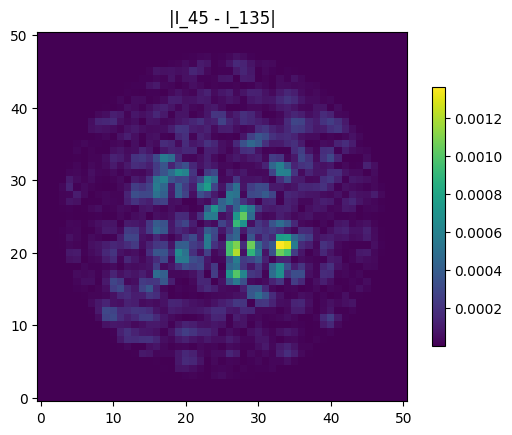

In [15]:
#plot 45/135 difference image
plt.imshow(np.abs(image_tot_corgi_45 - image_tot_corgi_135), origin='lower')
plt.title('|I_45 - I_135|')

co = plt.colorbar(shrink=0.7)

In [16]:
# generate subframe detector image 45/135
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime)
image_tot_corgi_sub_45= sim_scene.image_on_detector.data[0]
image_tot_corgi_sub_135= sim_scene.image_on_detector.data[1]

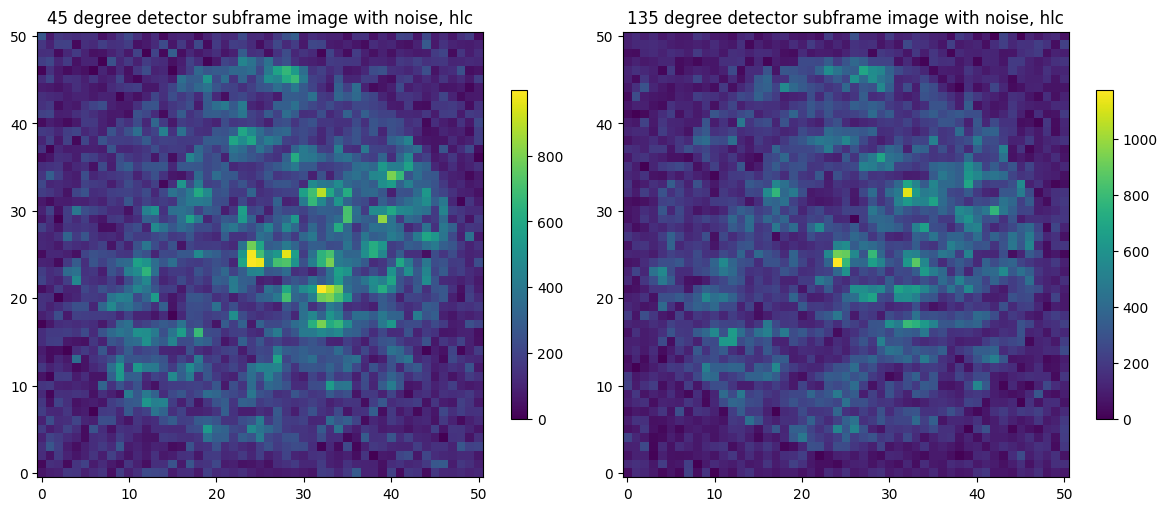

In [17]:
#plot noisy suframe images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im1 = axes[0].imshow(image_tot_corgi_sub_45, origin='lower')
axes[0].set_title('45 degree detector subframe image with noise, hlc')
fig.colorbar(im1, ax=axes[0], shrink=0.7)

im2 = axes[1].imshow(image_tot_corgi_sub_135, origin='lower')
axes[1].set_title('135 degree detector subframe image with noise, hlc')
fig.colorbar(im2, ax=axes[1], shrink=0.7)

plt.tight_layout()
plt.show()


In [18]:
#generate full frame detector image
exptime = 10000
sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True, loc_x = 512, loc_y = 512)
image_tot_corgi_full = sim_scene.image_on_detector[1].data

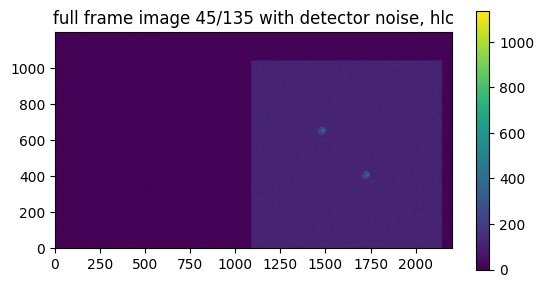

In [19]:
#plot full frame image
plt.imshow(image_tot_corgi_full,origin='lower')
plt.title('full frame image 45/135 with detector noise, hlc')

co = plt.colorbar(shrink=0.7)

Just for comparison, we will now generate a unpolarized PSF. Note that in addition to setting  `wollaston_prism` to `0`, we have also set `polaxis` to `-10` instead of `10`. This is because setting `polaxis=10` gives the average polarization aberration across all input and output polarization basis, but setting `polaxis=-10` incoherently averages the electric field output for all combinations of input and output polarizations. Doing so gives the most accurate model of polarization aberrations and speckle fields when no polarizer component is used

In [20]:
wollaston_prism = 0
polaxis = -10

In [21]:
#generate unpolarized image
optics_keywords = {'cor_type':cor_type, 'use_errors':2, 'polaxis':polaxis, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, wollaston_prism=wollaston_prism, optics_keywords=optics_keywords, if_quiet=True, integrate_pixels=True)
sim_scene = optics.get_host_star_psf(base_scene)
image_star_corgi_unpol = sim_scene.host_star_image.data
sim_scene = optics.inject_point_sources(base_scene, sim_scene)
image_comp_corgi_unpol = sim_scene.point_source_image.data
image_tot_corgi_unpol = image_star_corgi_unpol + image_comp_corgi_unpol

CorgiOptics initialized with proper keywords.


If we add either the 0 and 90 degree polarized images or the 45 and 135 degree polarized images, we should be able to recover the unpolarized image. We will plot the original unpolarized image, the 0+90 image, and the 45+135 image side by side to verify this. Since the wollaston prisms does not have a perfect transmission coefficient, the overall intensities of 0+90 and 45+135 will be slightly attenuated. However, everything else should be identical otherwise. This is verified by an actual numerical comparison of the images in `test_polarimetry.py` under the test folder. 

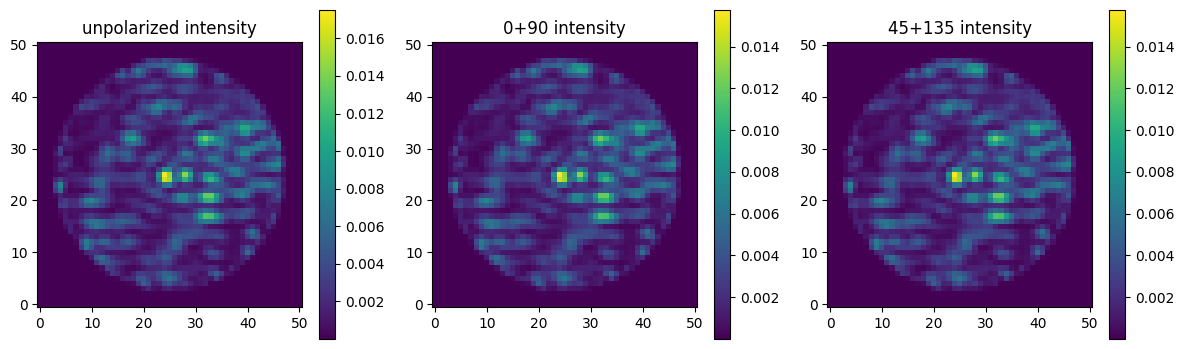

In [22]:
#plot unpolarized image, 0+90, and 45+135
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

im1 = axes[0].imshow(image_tot_corgi_unpol, origin='lower')
axes[0].set_title('unpolarized intensity')
plt.colorbar(im1, ax=axes[0], shrink=0.7)

im2 = axes[1].imshow(image_tot_corgi_horizontal + image_tot_corgi_vertical, origin='lower')
axes[1].set_title('0+90 intensity')
plt.colorbar(im2, ax=axes[1], shrink=0.7)

im3 = axes[2].imshow(image_tot_corgi_45 + image_tot_corgi_135, origin='lower')
axes[2].set_title('45+135 intensity')
plt.colorbar(im3, ax=axes[2], shrink=0.7)

plt.tight_layout()
plt.show()